In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import linearsolve as ls
np.set_printoptions(suppress=True)
from scipy.optimize import root,fsolve,broyden1,broyden2
%matplotlib inline

In [2]:
alpha = 0.36
beta = 0.989
delta = 0.019
eta = 1
psi = 1.34
sigma = 2
A = 1

rhoa = 0.95
gamma = 0.8
phi=0.5

In [3]:
r_ss = 1/beta
yk_ss= 1/alpha*(r_ss-1+delta)
ck_ss = yk_ss-delta


def func(n):
    return (1-alpha)/psi*beta*yk_ss**((sigma-alpha)/(1-alpha))*ck_ss**(-sigma) - (1-n)**-eta*n**sigma

n_ss = root(func,0.3)['x'][0]


nk_ss = (yk_ss)**(1/(1-alpha))

k_ss = n_ss/nk_ss
y_ss = yk_ss*k_ss

c_ss = ck_ss*k_ss
m_ss = c_ss
a_ss = 1
u_ss = 1
pi_ss = 1

lam_ss = beta*c_ss**-sigma
mu_ss = (1-beta)*c_ss**-sigma

In [4]:
ss = [a_ss,u_ss,m_ss,k_ss,pi_ss,r_ss,n_ss,c_ss,lam_ss,mu_ss,y_ss]

## Linear model

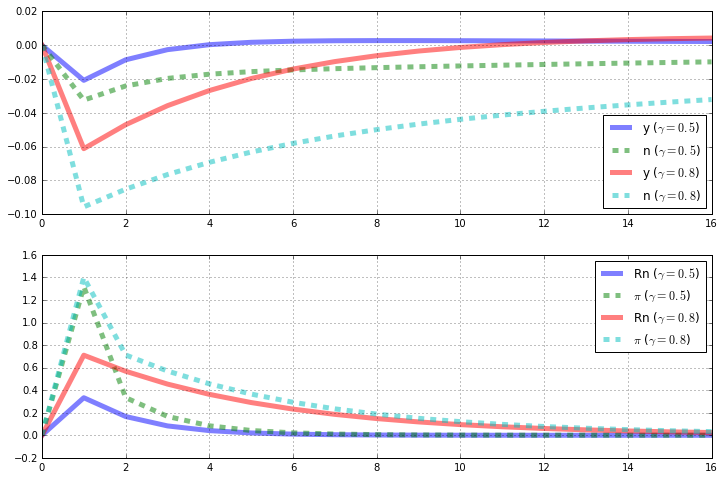

In [5]:
def equilibrium_equations(variables_forward,variables_current,parameters):
    
    # Parameters 
    p = parameters
    
    # Variables
    fwd = variables_forward
    cur = variables_current
    
    # Household Euler equation
    foc1 = p.alpha*cur.k+(1-p.alpha)*cur.n + fwd.a - cur.y
    foc2 = p.ck_ss*fwd.m + fwd.k - (1-p.delta)*cur.k - p.yk_ss*cur.y
    foc3 = p.alpha*p.yk_ss*(fwd.y - fwd.k) - cur.r
    foc4 = fwd.lam + cur.r - cur.lam
    foc5 = (1+p.eta*p.n_ss/(1-p.n_ss))*cur.n - cur.y - cur.lam
    foc6 = cur.r + fwd.pi - cur.rn
    foc7 = -p.sigma*fwd.maux-fwd.pi - cur.lam
    foc8 = cur.m-cur.pi+cur.u - fwd.m
    foc9 = cur.maux - fwd.m
    foc10= p.gamma*cur.u+p.phi*fwd.a - fwd.u
    foc11= p.rhoa*cur.a - fwd.a
    
    
    # Stack equilibrium conditions into a numpy array
    return np.array([
            foc1,
            foc2,
            foc3,
            foc4,
            foc5,
            foc6,
            foc7,
            foc8,
            foc9,
            foc10,
            foc11,
        ])

# Initialize the model
parameter_vals = [alpha,beta,delta,eta,psi,sigma,rhoa,gamma,phi,n_ss,yk_ss,ck_ss]
parameter_names = ['alpha','beta','delta','eta','psi','sigma','rhoa','gamma','phi','n_ss','yk_ss','ck_ss']

parameters = pd.Series(parameter_vals,index = parameter_names)

model = ls.model(equations = equilibrium_equations,
                 nstates=4,
                 varNames=['a', 'u', 'm', 'k', 'lam', 'pi', 'rn', 'r', 'n', 'y','maux'],
                 shockNames=['ea','eu','em','ek'],
                 parameters = parameters)

# # Compute the steady state numerically
guess = 0*np.array([1,1,10,10,1,1,0.5,2,1,1,1])
model.compute_ss(guess,method='fsolve')

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)

for gamma in [0.5,0.8]:
    
    model.parameters['gamma'] = gamma
    
    # Find the log-linear approximation around the non-stochastic steady state
    model.log_linear(islinear=True)

    # Solve the model
    model.solve_klein(model.a,model.b)

    # Compute impulse responses and plot
    model.impulse(T=17,t0=1,shock=None,percent=True)


    y = model.irs['eu']['y']
    n = model.irs['eu']['n']
    rn = model.irs['eu']['rn']
    pi = model.irs['eu']['pi']
    tme=rn.index
    
    ax1.plot(tme,y,lw=5,alpha=0.5,label='y ($\gamma='+str(gamma)+'$)')
    ax1.plot(tme,n,'--',lw=5,alpha=0.5,label='n ($\gamma='+str(gamma)+'$)')
    ax1.grid(True)
    ax1.legend(loc='lower right')
    ax2.plot(tme,rn,lw=5,alpha=0.5,label='Rn ($\gamma='+str(gamma)+'$)')
    ax2.plot(tme,pi,'--',lw=5,alpha=0.5,label='$\pi$ ($\gamma='+str(gamma)+'$)')
    ax2.grid(True)
    ax2.legend()

## Nonlinear model

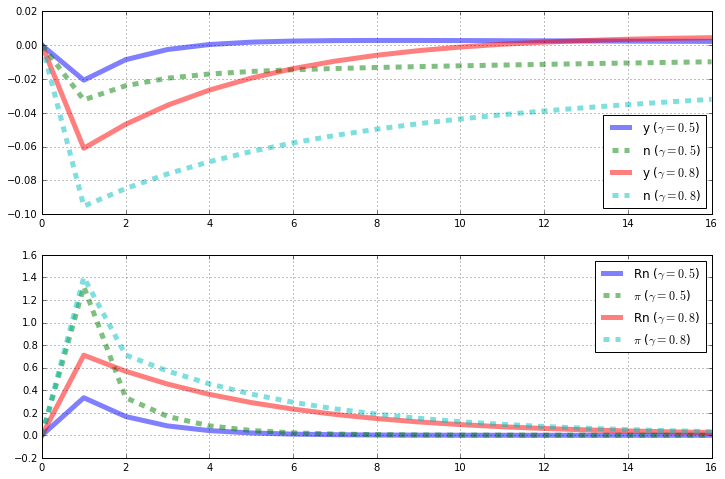

In [6]:
def equilibrium_equations(variables_forward,variables_current,parameters):
    
    # Parameters 
    p = parameters
    
    # Variables
    fwd = variables_forward
    cur = variables_current
    
    # Household Euler equation
    foc_1 = cur.a**p.rhoa - fwd.a
    foc_2 = cur.u**p.gamma*cur.a**p.phi - fwd.u
    foc_3 = cur.lam+cur.mu - cur.c**-p.sigma
    foc_4 = cur.lam*(1-p.alpha)*cur.y/cur.n - p.psi*(1-cur.n)**-p.eta
    foc_5 = p.beta*(fwd.lam*cur.Rn)/fwd.pi - cur.lam
    
    foc_6 = p.beta*(fwd.mu+fwd.lam)/fwd.pi - cur.lam
    foc_7 = p.beta*(fwd.lam*(p.alpha*fwd.y/fwd.k+1-p.delta)) - cur.lam
    foc_8 = cur.a*cur.k**alpha*cur.n**(1-p.alpha) - cur.y
    foc_9 = cur.c+fwd.k-(1-p.delta)*cur.k - cur.y
    foc_10 = cur.m/cur.pi*cur.u - fwd.m
    
    foc_11 = fwd.m - cur.c
    
    
    # Stack equilibrium conditions into a numpy array
    return np.array([
            foc_1,
            foc_2,
            foc_3,
            foc_4,
            foc_5,
            foc_6,
            foc_7,
            foc_8,
            foc_9,
            foc_10,
            foc_11
        ])

# Initialize the model
varNames=['a','u','m','k','pi','Rn','n','c','lam','mu','y']
shockNames=['ea','eu','em','ek']
parameter_vals = [alpha,beta,delta,eta,psi,sigma,rhoa,gamma,phi]
parameter_names = ['alpha','beta','delta','eta','psi','sigma','rhoa','gamma','phi']
parameters = pd.Series(parameter_vals,index = parameter_names)

model = ls.model(equations = equilibrium_equations,
                 nstates=4,
                 varNames=varNames,
                 shockNames=shockNames,
                 parameters = parameters)

guess = ss
# model.compute_ss(guess,method='fsolve')
model.set_ss(ss)

# model.set_ss(ss)

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)

for gamma in [0.5,0.8]:
    
    model.parameters['gamma'] = gamma
    
    # Find the log-linear approximation around the non-stochastic steady state
    model.log_linear()

    # Solve the model
    model.solve_klein(model.a,model.b)

    # Compute impulse responses and plot
    model.impulse(T=17,t0=1,shock=None,percent=True)


    y = model.irs['eu']['y']
    n = model.irs['eu']['n']
    rn = model.irs['eu']['Rn']
    pi = model.irs['eu']['pi']
    tme=rn.index
    
    ax1.plot(tme,y,lw=5,alpha=0.5,label='y ($\gamma='+str(gamma)+'$)')
    ax1.plot(tme,n,'--',lw=5,alpha=0.5,label='n ($\gamma='+str(gamma)+'$)')
    ax1.grid(True)
    ax1.legend(loc='lower right')
    ax2.plot(tme,rn,lw=5,alpha=0.5,label='Rn ($\gamma='+str(gamma)+'$)')
    ax2.plot(tme,pi,'--',lw=5,alpha=0.5,label='$\pi$ ($\gamma='+str(gamma)+'$)')
    ax2.grid(True)
    ax2.legend()